In [ ]:
#importing basic libraries
import numpy as np
pip install xgboost
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

raw_data = pd.read_csv('ardio_train.csv',sep=';')
# Check the data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
raw_data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
print(f"Missing values are present: {raw_data.isnull().sum().any()}")

Missing values are present: False


In [ ]:
raw_data.drop('id',axis=1,inplace=True)
raw_data.age = np.round(raw_data.age/365.25,decimals=1)
raw_data.gender = raw_data.gender.replace(2,0)

In [ ]:
raw_data.duplicated().sum()

674

In [ ]:
raw_data.drop_duplicates(inplace=True)

I will remove extremely rare cases of height and weight. As data is quite big, there will be no prblem while modelling.

In [ ]:
raw_data = raw_data[(raw_data['height']<250) & (raw_data['weight']>20.0)]

There are many outliers in height and weight features. I combine both of these into a new feature bmi.

In [ ]:
raw_data["bmi"] = (raw_data["weight"]/ (raw_data["height"]/100)**2).round(1)

In [ ]:
data= raw_data[(raw_data['bmi']>10) & (raw_data['bmi']<100)].copy()

In [ ]:
data.drop(['weight','height'],axis=1,inplace=True)

In [ ]:
data= data[(data['ap_lo']<360) & (data['ap_hi']<360)].copy()
data= data[(data['ap_lo']>20) & (data['ap_hi']>20)].copy()
data=data[data['ap_hi']>data['ap_lo']]

In [ ]:
#creating dummy variables for categorical column
data['cholesterol']=data['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data['gluc']=data['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
dummies = pd.get_dummies(data[['cholesterol','gluc']],drop_first=True)
final_data = pd.concat([data,dummies],axis=1)
final_data.drop(['cholesterol','gluc'],axis=1,inplace=True)
final_data.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_normal,cholesterol_well above normal,gluc_normal,gluc_well above normal
0,50.4,0,110,80,0,0,1,0,22.0,1,0,1,0
1,55.4,1,140,90,0,0,1,1,34.9,0,1,1,0
2,51.6,1,130,70,0,0,0,1,23.5,0,1,1,0
3,48.2,0,150,100,0,0,1,1,28.7,1,0,1,0
4,47.8,1,100,60,0,0,0,0,23.0,1,0,1,0


### Splitting and Standardizing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(final_data.drop('cardio',axis=1),final_data.cardio,test_size=0.30)

to_be_scaled_feat = ['age', 'ap_hi', 'ap_lo','bmi']
other_feat = ['gender', 'cholesterol_normal', 'cholesterol_well above normal',
       'gluc_normal', 'gluc_well above normal', 'smoke', 'alco', 'active']
scaler=StandardScaler()
scaler.fit(X_train[to_be_scaled_feat])
X_train[to_be_scaled_feat] = scaler.transform(X_train[to_be_scaled_feat])
X_test[to_be_scaled_feat] = scaler.transform(X_test[to_be_scaled_feat])

### Modelling

In [1]:
# importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,accuracy_score,classification_report

classifiers = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Support Vector Machines' : SVC(),
    'K-nearest Neighbors' : KNeighborsClassifier(),
    'XGBoost' : XGBClassifier()
}
results=pd.DataFrame(columns=['Accuracy in %','F1-score'])
for method,func in classifiers.items():
    func.fit(X_train,y_train)
    pred = func.predict(X_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2)]
results

ModuleNotFoundError: No module named 'xgboost'

# Improving Accuracy by Hyperparameter Tuning

## K- Nearest Neighbors (by elbow method)

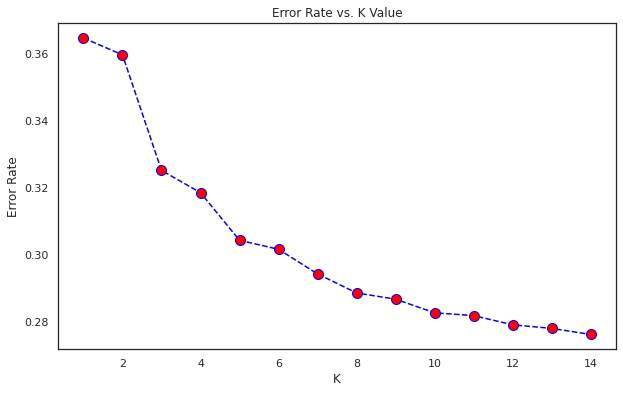

In [ ]:
error_rate = []

for i in range(1,15):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,15),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     10265
           1       0.75      0.66      0.70     10127

    accuracy                           0.72     20392
   macro avg       0.72      0.72      0.72     20392
weighted avg       0.72      0.72      0.72     20392



In [ ]:
results.loc['K-nearest Neighbors(Improved)']= [100*np.round(accuracy_score(y_test,knn_pred),decimals=4),
                         round(f1_score(y_test,knn_pred),2)]

By using **elbow method** we have increased accuracy of this model from 69.4% to 72%.

## Random Forest (by GridSearchCV)

In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=1)
grid.fit(X_train,y_train)
grid.best_params_

NameError: name 'X_train' is not defined

In [ ]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10265
           1       0.75      0.69      0.72     10127

    accuracy                           0.73     20392
   macro avg       0.74      0.73      0.73     20392
weighted avg       0.74      0.73      0.73     20392



# Deep Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#splitting further into validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.20)

model = Sequential()
model.add(Dense(12,activation='relu'))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.fit(x=X_train.values,y=y_train.values,
          validation_data=(X_val,y_val.values),
          batch_size=100,epochs=150,callbacks=[early_stop])

Epoch 1/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5740 - val_loss: 0.5496
Epoch 2/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5548 - val_loss: 0.5499
Epoch 3/150
381/381 [==============================] - 1s 2ms/step - loss: 0.5523 - val_loss: 0.5468
Epoch 4/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5509 - val_loss: 0.5467
Epoch 5/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5486 - val_loss: 0.5465
Epoch 6/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5489 - val_loss: 0.5476
Epoch 7/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5477 - val_loss: 0.5460
Epoch 8/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5473 - val_loss: 0.5455
Epoch 9/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5475 - val_loss: 0.5456
Epoch 10/150
381/381 [==============================] - 1s 3ms/step - loss: 0.5473 - val_lo

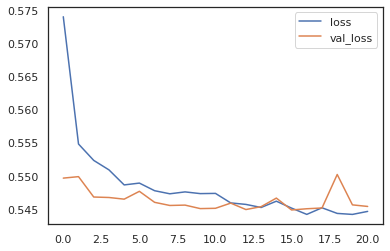

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot();

In [ ]:
dnn_pred = model.predict_classes(X_test)
print(classification_report(y_test,dnn_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     10265
           1       0.75      0.71      0.73     10127

    accuracy                           0.73     20392
   macro avg       0.73      0.73      0.73     20392
weighted avg       0.73      0.73      0.73     20392



# Results

In [ ]:
results.loc['Random Forest(Improved)']= [100*np.round(accuracy_score(y_test,grid_pred),decimals=4),
                         round(f1_score(y_test,grid_pred),2)]
results.loc['Deep Neural Network']= [100*np.round(accuracy_score(y_test,dnn_pred),decimals=4),
                         round(f1_score(y_test,dnn_pred),2)]
results.sort_values(by='Accuracy in %',ascending=False).style.highlight_max()

,Accuracy in %,F1-score
Support Vector Machines,73.560000,0.720000
Random Forest(Improved),73.480000,0.720000
Deep Neural Network,73.410000,0.730000
XGBoost,73.240000,0.720000
Logistic Regression,73.060000,0.710000
K-nearest Neighbors(Improved),72.100000,0.700000
K-nearest Neighbors,69.570000,0.690000
Random Forest,69.500000,0.690000
Decision Tree,63.090000,0.630000
